# Explaining outcomes from a black box model

This notebook demonstrates how SLISE can be used to explain outcomes from complex models on high-dimensional data.
To this end we use a dataset of handwritten digits and a convolutional neural network.

### Considerations

SLISE works with vectors and linear models. This means that it discards the spatial information of images (and cannot consider translations). Additionally, the visualisation of linear models on colour images is challenging.
Thus, SLISE should normally not be used, as such, on images.

However, this dataset is a special case since all the images are black-and-white and have been rotated, centered, and scaled, which removes much of the spatial variation. Furthermore, there is lots of overlapping information in adjacent pixels.

## Prerequisites

The example in this notebook assumes that SLISE is installed, which can be done with:
```sh
pip install https://github.com/edahelsinki/pyslise
```
We also need Keras (Tensorflow) for the neural network:

In [40]:
import numpy as np
from tensorflow import keras
import slise
from slise.plot import BW_COLORMAP
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

plt.rcParams['figure.figsize'] = [10, 6]

## Dataset

Here we use the standard MNIST dataset. Note the usage of label smoothing to combat overconfident models.

In [2]:
# Data parameters
num_classes = 10
label_smoothing = 0.2

# the data, split between train and test sets
(x_train, c_train), (x_test, c_test) = keras.datasets.mnist.load_data()
x_train.shape = (-1, 28, 28, 1)
x_test.shape = (-1, 28, 28, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(c_train, num_classes)
y_test = keras.utils.to_categorical(c_test, num_classes)

# Apply label smoothing
if label_smoothing > 0:
    y_train = y_train * (1.0 - label_smoothing) + label_smoothing / num_classes

# Scale images to the [-1, 1] range
x_train = x_train.astype("float32") / 127.5 - 1.0
x_test = x_test.astype("float32") / 127.5 - 1.0

## Model

As the black box model we use a simple convolutional neural network. The code is adapted from: [https://keras.io/examples/vision/mnist_convnet/](https://keras.io/examples/vision/mnist_convnet/).

In [3]:
# Define the model
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [4]:
# Training parameters
batch_size = 128
epochs = 5

# Train the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/5
422/422 [==============================] - 11s 26ms/step - loss: 1.1561 - accuracy: 0.9016 - val_loss: 0.9826 - val_accuracy: 0.9825
Epoch 2/5
422/422 [==============================] - 11s 26ms/step - loss: 1.0084 - accuracy: 0.9726 - val_loss: 0.9526 - val_accuracy: 0.9863
Epoch 3/5
422/422 [==============================] - 11s 26ms/step - loss: 0.9852 - accuracy: 0.9791 - val_loss: 0.9401 - val_accuracy: 0.9887
Epoch 4/5
422/422 [==============================] - 11s 26ms/step - loss: 0.9753 - accuracy: 0.9823 - val_loss: 0.9350 - val_accuracy: 0.9907
Epoch 5/5
422/422 [==============================] - 11s 26ms/step - loss: 0.9682 - accuracy: 0.9843 - val_loss: 0.9323 - val_accuracy: 0.9907
Test loss: 0.26803427934646606
Test accuracy: 0.9883999824523926


## Explanation

The first step is to select which image to explain. We also subsample the dataset such that 50% of the images are of the same digit as the image we are explaining and 50% are of other digits.

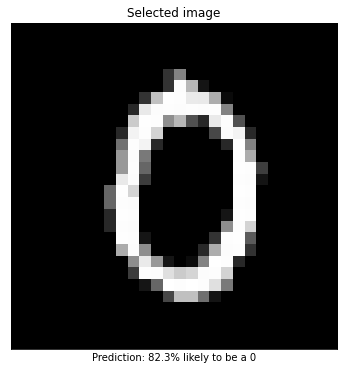

In [216]:
digit = 0

# Balance the classes
mask = (c_test == digit) + (np.random.uniform(0, 1, len(c_test)) < 1 / num_classes)

# Select item
item =  np.where(c_test[mask] == digit)[0][12]

# Show the selected item
plt.imshow(x_test[mask][item,:,:,0], cmap=BW_COLORMAP)
plt.xticks([])
plt.yticks([])
plt.title("Selected image")
plt.xlabel(f"Prediction: {p_test[mask][item, digit] * 100:.1f}% likely to be a {digit}")
plt.show()

To create explanations with SLISE we need a dataset of predictions (here we use the test-set mostly because it is smaller). 
Normally, it is a good idea to normalise the data matrix, but in this case the pixel values are already guaranteed to be in $[-1, 1]$. So, the only thing we need to do is to flatten the images into vectors:

In [217]:
x_explain = np.reshape(x_test[mask, :, :, :], (-1, 28 * 28))

The last activation function of a (classifier) neural network is often either a `sigmoid` or a `softmax`. These transform values from real space to (pseudo) probabilities. The non-linearity of `sigmoid` and `softmax` decreases the differences between the predictions (especially around zero and one), which makes creating explanations more difficult. Additionally, since the explanation given by SLISE are in the form of linear approximations it would be benefitial if the predictions are in real space. Thus, it is recommended to invert the final `sigmoid` or `softmax`.

The `sigmoid` function has an unique inverse in the `logit` function (and SLISE can do this inversion for us if we specify `logit=True` as a parameter). However, the `softmax` function does not have an unique inverse. The inverse is $log(x) + c$, where $c$ is a constant. Here we (arbitrarily) choose $c$ to be the negation of the median:

In [218]:
# Extract predictions
p_test = model.predict(x_test)
# Invert softmax
y_explain = np.log(p_test[mask, digit])
y_explain -= np.median(y_explain)

Now we can use SLISE to explain why this image is predicted to be a five (the warning about maximum iterations can in most cases be safely ignored):

In [237]:
explanation = slise.explain(x_explain, y_explain, epsilon=0.2, x=x_explain[item], y=y_explain[item], lambda1=0.15, lambda2 = 0.15)

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(


First we need to do a quick sanity check to make sure that the explanation considers both classes (otherwise the approximation is likely to be close to constant, which would be a poor explanation):

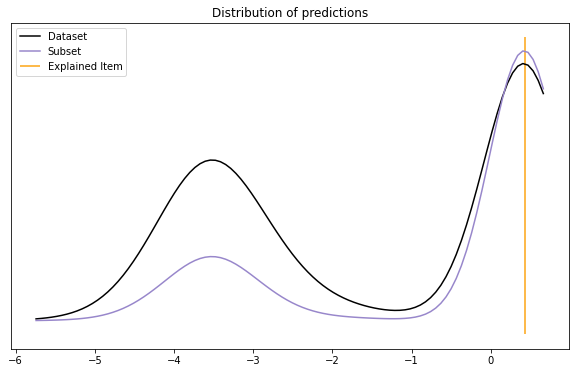

Subset size: 0.6336320506062203


In [238]:
subset = explanation.subset()
kde1 = gaussian_kde(explanation.Y, 0.25)
kde2 = gaussian_kde(explanation.Y[subset], 0.25)
lim = np.linspace(explanation.Y.min() - 0.1, explanation.Y.max() + 0.1, 100)
ax = plt.gca()
ax.plot(lim, kde1(lim), color="black", label="Dataset")
ax.plot(lim, kde2(lim) * subset.mean(), color="#9887cb", label="Subset")
ax.relim()
ax.vlines(explanation.y, *ax.get_ylim(), color="#fda411", label="Explained Item")
ax.set_yticks([])
ax.legend()
ax.set_title("Distribution of predictions")
plt.show()
print("Subset size:", subset.mean())

Now we can look at the actual explanation. Keep in mind that the neural network sees the images as pixels (while humans might see them as, e.g., pen strokes). Thus, we should expect an explanation in terms of pixels. The explanation consists of a local approximation of the black box model (neural network) using a linear model. This means that, for each pixel, the explanation tells us whether a white pixel supports or disputes the classification (and vice versa for black pixels).

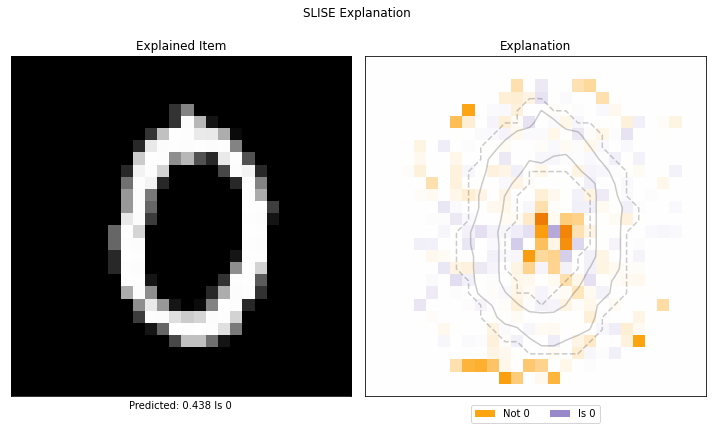

In [239]:
explanation.plot_image(28, 28, classes=["Not " + str(digit), "Is " + str(digit)])

Here we can see that the distinguising feature of zeros is the "hole" in the middle (it being black supports the classification).

Another curious artifact of the data / model is that some digits (ones and sevens?) extend lower down than others. This makes it easy to distinguish those from the rest, solely based on that feature, which might not be the desired behaviour. This is one way explanations can be used to "debug" models.